# 用 LSTM 做时间序列预测

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

D:\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

## 导入数据

   passengers
0         112
1         118
2         132
     passengers
142         390
143         432

dataset's shape:  (144, 1)


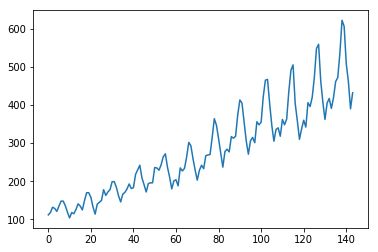

In [3]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python')
print(dataframe.head(3)) #-查看dataframe的前几行，默认为5
print(dataframe.tail(2)) 

dataset = dataframe.values #-Return a Numpy representation of the DataFrame
dataset = dataset.astype('float32') #-将整型变为float

print("\ndataset's shape: ", dataset.shape)
plt.plot(dataset)
plt.show()

## 数据转化与处理

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(len(dataset) == len(train)+len(test))

96 48
True


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): #原文-1错了，"for i in range(n)"为[0,n-1]
        a = dataset[i:(i+look_back), 0] # 不包括i+look_back
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #单值
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(len(trainX), len(testX)) #应等于train-look_back
# print(trainX[0:5,:]) #先注释掉MinMax处理再检查
# print(trainY[0:5])

95 47


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: **[samples, time steps, features]**.

Currently, our data is in the form: **[samples, features]** and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [8]:
# reshape input to be [samples, time steps, features]
print(trainX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) 
print(trainX.shape)
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# print(testX)

(95, 1)
(95, 1, 1)


## 建立 LSTM 模型

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) #verbose：debug信息

## 预测评估

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.93 RMSE
Test Score: 48.28 RMSE


## 画出结果

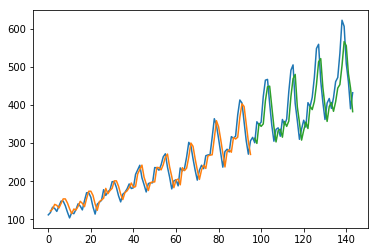

In [158]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict #不包括len(trainPredict)+look_back

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+look_back*2:len(dataset), :] = testPredict #根据create_dataset()的小bug作相应更改，

# 注意由于划分了训练集和测试集，总的samples数目会减少：len(dataset - lookback) - (len(trainX)+len(testX))

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

参考：[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"Title")